In [10]:
import glob
import os
import pandas as pd
from io import StringIO
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

plt.rc('font', family='sans-serif')#, serif='Times')
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=11)
#plt.rcParams['mathtext.fontset'] = 'stix'
#plt.rcParams['font.family'] = 'STIXGeneral'
params = {
'text.usetex': True,
#'font.size': 15,
'text.latex.unicode': True
}
plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Variable $k$

### Ref-Seq assembly data

In [2]:
k_array = np.arange(10, 24)

In [3]:
!ls ~/big_graph/refseq/refseq_k10/graph_refseq_k10.dbg

/cluster/home/mikhaika/big_graph/refseq/refseq_k10/graph_refseq_k10.dbg


In [4]:
sizes = [os.path.getsize('../big_graph/refseq/refseq_k{}/graph_refseq_k{}.dbg'.format(x, x)) for x in k_array]
sizes

[5017397,
 19957085,
 79716413,
 318783677,
 1275200189,
 5100406198,
 20193422370,
 70555357553,
 180029209052,
 320880966947,
 424795775328,
 470859116657,
 490467611111,
 503062440506]

In [5]:
num_edges = [4194305,
16777217,
67108865,
268435457,
1073741825,
4294807964,
17004180213,
58827897766,
147478598494,
261992234631,
355110450523,
411025684461,
441788978532,
459869414309,
]

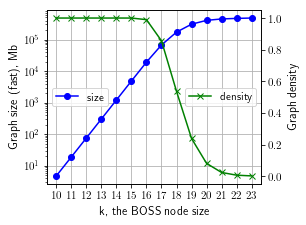

In [6]:
width = 3.487 * 1.5
height = width / 1.618

fig, ax = plt.subplots(1, 1, figsize=(width / 1.2, height))
#ax.set_title('RefSeq graph, with replaced \'N\'s')
#ax.set_title('RefSeq assembly graph')

ax.plot(np.array(k_array), np.array(sizes) / 2**20, marker='o', label='size', c='b')
ax.set_yscale('log')
ax.set_ylabel('Graph size (fast), Mb')
ax.set_xlabel('k, the BOSS node size')
ax.set_xticks(np.array(k_array))
ax.grid(True)
ax.legend(loc='center left')

ax2 = ax.twinx()
ax2.plot(np.array(k_array), num_edges / 4 ** (np.array(k_array) + 1), marker='x', label='density', c='g')
#ax2.set_yscale('log')
ax2.set_ylabel('Graph density')
ax2.legend(loc='center right')

plt.tight_layout()
plt.savefig('refseq_scalability.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Kingsford data

In [7]:
k_array = np.concatenate((np.arange(5, 21), np.arange(22, 34, 2)))

In [8]:
!ls ~/big_graph/kingsford/var_k/graph_kingsford_k*.dbg

ls: cannot access '/cluster/home/mikhaika/big_graph/kingsford/var_k/graph_kingsford_k*.dbg': No such file or directory


In [9]:
sizes = [os.path.getsize('../big_graph/kingsford/var_k/graph_kingsford_k{}.dbg'.format(x, x)) for x in k_array]
sizes

FileNotFoundError: [Errno 2] No such file or directory: '../big_graph/kingsford/var_k/graph_kingsford_k5.dbg'

In [ ]:
num_edges = [15626,
78126,
390617,
1902278,
7468325,
24194804,
72215346,
197636600,
512173368,
1326508825,
2934716087,
4955736317,
6790193411,
8184346383,
9226858039,
10082499128,
10868326297,
11479986324,
12901835746,
14190173930,
15700483703,
17261067050,
]

In [ ]:
width = 3.487 * 1.5
height = width / 1.618

fig, ax = plt.subplots(1, 1, figsize=(width / 1.2, height))
#ax.set_title('Kingsford graph, with replaced \'N\'s')
#ax.set_title('Kingsford assembly graph')

ax.plot(np.array(k_array), np.array(sizes) / 2**20, marker='o', label='size', c='b')
ax.set_yscale('log')
ax.set_ylabel('Graph size (fast), Mb')
ax.set_xlabel('k, the BOSS node size')
#ax.set_xticks(np.array(k_array))
ax.set_xticks([6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32])
ax.grid(True)
ax.legend(loc=(0.7, 0.75))

ax2 = ax.twinx()
ax2.plot(np.array(k_array), num_edges / 5 ** (np.array(k_array) + 1), marker='x', label='density', c='g')
#ax2.set_yscale('log')
ax2.set_ylabel('Graph density')
ax2.legend(loc=(0.6, 0.1))

plt.tight_layout()
plt.savefig('kingsford_scalability.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Plots

In [ ]:
k_array_refseq = np.arange(10, 24)
sizes_refseq = [os.path.getsize('../big_graph/refseq/refseq_k{}/graph_refseq_k{}.dbg'.format(x, x)) for x in k_array_refseq]
num_edges_refseq = [4194305,
16777217,
67108865,
268435457,
1073741825,
4294807964,
17004180213,
58827897766,
147478598494,
261992234631,
355110450523,
411025684461,
441788978532,
459869414309,
]

In [ ]:
width = 3.487 * 1.5
height = width / 1.618

fig, ax = plt.subplots(1, 1, figsize=(width / 1.2, height))
#ax.set_title('RefSeq graph, with replaced \'N\'s')
#ax.set_title('RefSeq assembly graph')

ax1_plot1 = ax.plot(np.array(k_array_refseq), np.array(sizes_refseq) / 2**20, marker='o', label='RS: size', c='b')
ax1_plot2 = ax.plot(np.array(k_array), np.array(sizes) / 2**20, marker='o', label='KF: size', c='r')
ax.set_yscale('log')
ax.set_ylabel('Graph size (fast), Mb')
ax.set_xlabel('$k$, the BOSS node size')
#ax.set_xticks(np.array(k_array))
ax.set_xticks([6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32])
ax.grid(True)

ax2 = ax.twinx()
ax2_plot1 = ax2.plot(np.array(k_array_refseq), num_edges_refseq / 4 ** (np.array(k_array_refseq) + 1), marker='x', label='RS: density', c='b')
ax2_plot2 = ax2.plot(np.array(k_array), num_edges / 5 ** (np.array(k_array) + 1), marker='x', label='KF: density', c='r')
#ax2.set_yscale('log')
ax2.set_ylabel('Graph density')

lns = ax1_plot1 + ax1_plot2 + ax2_plot1 + ax2_plot2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='center right')

plt.tight_layout()
plt.savefig('graph_k_scalability.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Variable size of the input data

### Kingsford

files = pd.read_csv('~/projects2014-metagenome/scripts/kingsford/kingsford_filtered_list.txt', header=None)[0].values

np.random.seed(42)
np.random.shuffle(files)

with open('kingsford_filtered_list_shuffled.txt', 'w') as f:
    for fname in files:
        f.write(fname)
        f.write('\n')
!mv kingsford_filtered_list_shuffled.txt ~/projects2014-metagenome/scripts/kingsford/kingsford_filtered_list_shuffled.txt

In [11]:
files = pd.read_csv('~/projects2014-metagenome/scripts/kingsford/kingsford_filtered_list_shuffled.txt', header=None)[0].values

In [12]:
!ls ~/big_graph/kingsford/input_size/graph_kingsford_k19_cols*

/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_k19_cols1032.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_k19_cols1204.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_k19_cols1376.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_k19_cols1548.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_k19_cols172.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_k19_cols1720.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_k19_cols1892.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_k19_cols2064.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_k19_cols2236.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_k19_cols2408.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_k19_cols2580.dbg
/cluster/home/mikhaika/big_graph/kingsford/i

In [13]:
step = 172
num_cols = np.arange(0, len(files) + step - 1, step)[1:]

In [14]:
input_kingsford = [sum([os.path.getsize(x) for x in files[:x]]) for x in num_cols]

In [15]:
sizes_kingsford = [os.path.getsize('../big_graph/kingsford/input_size/graph_kingsford_k19_cols{}.dbg'.format(x))
                    for x in num_cols]
sizes_kingsford

[707933385,
 1022225551,
 1435919673,
 1626346341,
 1801949880,
 1945362379,
 2104574497,
 2266983801,
 2395168201,
 2570433687,
 2718633575,
 2993682300,
 3090604989,
 3194197988,
 3365264248]

### Kingsford both strands

In [16]:
files = pd.read_csv('~/projects2014-metagenome/scripts/kingsford/kingsford_filtered_list_shuffled.txt', header=None)[0].values

In [17]:
!ls ~/big_graph/kingsford/input_size/graph_kingsford_BS_k19_cols*

/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_BS_k19_cols1032.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_BS_k19_cols1204.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_BS_k19_cols1376.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_BS_k19_cols1548.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_BS_k19_cols172.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_BS_k19_cols1720.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_BS_k19_cols1892.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_BS_k19_cols2064.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_BS_k19_cols2236.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_BS_k19_cols2408.dbg
/cluster/home/mikhaika/big_graph/kingsford/input_size/graph_kingsford_BS_k19_cols2580.dbg
/cluster/ho

In [18]:
step = 172
num_cols = np.arange(0, len(files) + step - 1, step)[1:]

In [19]:
input_kingsford = [sum([os.path.getsize(x) for x in files[:x]]) for x in num_cols]

In [20]:
sizes_kingsford_both = [os.path.getsize('../big_graph/kingsford/input_size/graph_kingsford_BS_k19_cols{}.dbg'.format(x))
                            for x in num_cols]
sizes_kingsford_both

[917405182,
 1348195470,
 1887655759,
 2152077709,
 2379204462,
 2580591669,
 2799495969,
 3012507939,
 3173596704,
 3433930429,
 3644262191,
 4013426491,
 4149606441,
 4315480913,
 4560443614]

In [21]:
# width = 3.487 * 1.5
# height = width / 1.618

# fig, ax = plt.subplots(1, 1, figsize=(width / 1.2, height))
# #ax.set_title('RefSeq graph, with replaced \'N\'s')
# #ax.set_title('RefSeq assembly graph')

# #ax1_plot1 = ax.plot(np.array(k_array_refseq),
# #                    np.array(sizes_refseq) / 2**20, marker='o', label='RS: size', c='b')
# ax1_plot2 = ax.plot(np.array(input_kingsford) / 2**30,
#                     np.array(sizes_kingsford) / 2**30, marker='o', label='KF: size', c='r')
# #ax.set_yscale('log')
# ax.set_ylabel('Graph size (fast), Gb')
# ax.set_xlabel('Input data size, Gb')
# #ax.set_xticks(np.array(k_array))
# ax.grid(True)
# ax.legend(loc='center right')

# plt.title('Usual filtering')
# plt.tight_layout()
# plt.savefig('graph_input_scalability.pdf', format='pdf', bbox_inches='tight')
# plt.show()

### Kingsford with N

files = pd.read_csv('~/projects2014-metagenome/scripts/kingsford/kingsford_filtered_list.txt', header=None)[0].values

np.random.seed(42)
np.random.shuffle(files)

with open('kingsford_filtered_list_shuffled.txt', 'w') as f:
    for fname in files:
        f.write(fname)
        f.write('\n')
!mv kingsford_filtered_list_shuffled.txt ~/projects2014-metagenome/scripts/kingsford/kingsford_filtered_list_shuffled.txt

In [22]:
files = pd.read_csv('~/projects2014-metagenome/scripts/kingsford/with_N_kingsford_filtered_list_shuffled.txt', header=None)[0].values

In [23]:
!ls ~/big_graph/kingsford/with_N/partitions/graph_kingsford_k19_cols*

/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_k19_cols1050.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_k19_cols1225.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_k19_cols1400.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_k19_cols1575.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_k19_cols175.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_k19_cols1750.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_k19_cols1925.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_k19_cols2100.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_k19_cols2275.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_k19_cols2450.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/

In [24]:
step = 175
num_cols = np.arange(0, len(files) + step - 1, step)[1:]

In [25]:
input_kingsford_with_N = [sum([os.path.getsize(x) for x in files[:x]]) for x in num_cols]

FileNotFoundError: [Errno 2] No such file or directory: '/cluster/work/grlab/projects/metagenome/benchmark_kingsford/data_fasta/filtering__0_1__150_3__250_10__500_20__1500_50/SRR837466.filter_k19_s2_4.fastq.gz'

In [26]:
sizes_kingsford_with_N = [os.path.getsize('../big_graph/kingsford/with_N/partitions/graph_kingsford_k19_cols{}.dbg'.format(x))
                    for x in num_cols]
sizes_kingsford_with_N

[1641841495,
 2984646351,
 3951455337,
 4784982753,
 5498803803,
 6234462800,
 6843575136,
 7363018259,
 7793657928,
 8419176779,
 8961389017,
 9393773730,
 9777334609,
 10334399845,
 10715722488]

In [27]:
# width = 3.487 * 1.5
# height = width / 1.618

# fig, ax = plt.subplots(1, 1, figsize=(width / 1.2, height))
# #ax.set_title('RefSeq graph, with replaced \'N\'s')
# #ax.set_title('RefSeq assembly graph')

# #ax1_plot1 = ax.plot(np.array(k_array_refseq),
# #                    np.array(sizes_refseq) / 2**20, marker='o', label='RS: size', c='b')
# ax1_plot2 = ax.plot(np.array(input_kingsford_with_N) / 2**30,
#                     np.array(sizes_kingsford_with_N) / 2**30, marker='o', label='KF: size', c='r')
# #ax.set_yscale('log')
# ax.set_ylabel('Graph size (fast), Gb')
# ax.set_xlabel('Input data size, Gb')
# #ax.set_xticks(np.array(k_array))
# ax.grid(True)
# ax.legend(loc='center right')

# plt.title('Usual filtering')
# plt.tight_layout()
# plt.savefig('graph_input_scalability.pdf', format='pdf', bbox_inches='tight')
# plt.show()

### Kingsford annotation

In [28]:
sizes_king_anno = [os.path.getsize('../big_graph/kingsford/with_N/partitions/graph_kingsford_k19_cols_{}.color.annodbg'.format(x))
                    for x in num_cols[:9]]
sizes_king_anno

[3535192160,
 8253905738,
 12134994454,
 15654370256,
 21366100290,
 26136838729,
 30499974125,
 34710248027,
 38608446563]

### Kingsford without small files, $\geq250$ Mb

In [29]:
files = pd.read_csv('~/projects2014-metagenome/scripts/kingsford/'
                    'with_N_kingsford_filtered_list_shuffled_filtered.txt', header=None)[0].values

In [30]:
!ls ~/big_graph/kingsford/with_N/partitions/graph_kingsford_without_small_k19_cols*

/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_without_small_k19_cols1035.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_without_small_k19_cols115.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_without_small_k19_cols1150.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_without_small_k19_cols1265.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_without_small_k19_cols1380.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_without_small_k19_cols1495.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_without_small_k19_cols1610.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_without_small_k19_cols1725.dbg
/cluster/home/mikhaika/big_graph/kingsford/with_N/partitions/graph_kingsford_without_small_k19_cols230.dbg
/cluster/home/mikhaika/big_gra

In [31]:
step = 115
num_cols = np.arange(0, len(files) + step - 1, step)[1:]

In [32]:
input_kingsford_strong = [sum([os.path.getsize(x) for x in files[:x]]) for x in num_cols]

FileNotFoundError: [Errno 2] No such file or directory: '/cluster/work/grlab/projects/metagenome/benchmark_kingsford/data_fasta/filtering__0_1__150_3__250_10__500_20__1500_50/SRR1060793.filter_k19_s19_4.fastq.gz'

In [33]:
sizes_kingsford_strong = [os.path.getsize('../big_graph/kingsford/with_N/partitions/'
                                          'graph_kingsford_without_small_k19_cols{}.dbg'.format(x))
                            for x in num_cols]
sizes_kingsford_strong

[1227026378,
 1911213924,
 2610725129,
 3273616932,
 3733901830,
 4159863783,
 4498350506,
 4831177003,
 5161836752,
 5510172893,
 5773939953,
 6133990417,
 6409705251,
 6693444324,
 7048497247]

In [34]:
# width = 3.487 * 1.5
# height = width / 1.618

# fig, ax = plt.subplots(1, 1, figsize=(width / 1.2, height))
# #ax.set_title('RefSeq graph, with replaced \'N\'s')
# #ax.set_title('RefSeq assembly graph')

# #ax1_plot1 = ax.plot(np.array(k_array_refseq),
# #                    np.array(sizes_refseq) / 2**20, marker='o', label='RS: size', c='b')
# ax1_plot2 = ax.plot(np.array(input_kingsford) / 2**30,
#                     np.array(sizes_kingsford) / 2**30, marker='o', label='KF: size', c='r')
# #ax.set_yscale('log')
# ax.set_ylabel('Graph size (fast), Gb')
# ax.set_xlabel('Input data size, Gb')
# #ax.set_xticks(np.array(k_array))
# ax.grid(True)
# ax.legend(loc='center right')

# plt.title('Aggressive filtering, 10+')
# plt.tight_layout()
# plt.savefig('graph_input_scalability.pdf', format='pdf', bbox_inches='tight')
# plt.show()

### TCGA

In [35]:
# files = pd.read_csv('~/projects2014-metagenome/scripts/TCGA/files.txt', header=None)[0].values

In [36]:
# np.random.seed(42)
# np.random.shuffle(files)

In [37]:
# with open('TCGA_shuffled.txt', 'w') as f:
#     for fname in files:
#         f.write(fname)
#         f.write('\n')
# !mv TCGA_shuffled.txt ~/projects2014-metagenome/scripts/TCGA/TCGA_shuffled.txt

In [38]:
files = pd.read_csv('~/projects2014-metagenome/scripts/TCGA/TCGA_shuffled.txt', header=None)[0].values

In [39]:
sizes = np.array([os.path.getsize(x) for x in files])

In [40]:
sizes = sizes * pd.read_csv('~/projects2014-metagenome/scripts/TCGA/TCGA_shuffled_filter_stats.txt', sep='\s+').RemainingRatio.values

In [41]:
!ls ~/big_graph/TCGA/input_size/graph_TCGA_k20_cols*

/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_k20_cols1015.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_k20_cols1160.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_k20_cols1305.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_k20_cols145.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_k20_cols1450.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_k20_cols1595.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_k20_cols1740.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_k20_cols1885.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_k20_cols2030.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_k20_cols290.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_k20_cols435.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_k20_cols580.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_k20_cols725.dbg
/clu

In [42]:
step = 145
num_cols = np.arange(0, len(files) + step - 1, step)[1:]

In [43]:
input_TCGA = np.array([sum(sizes[:x]) for x in num_cols])

In [44]:
num_cols_TCGA = np.arange(145, len(files) + 145 - 1, 145)

In [45]:
sizes_TCGA = [os.path.getsize('../big_graph/TCGA/input_size/graph_TCGA_k20_cols{}.dbg'.format(x))
                    for x in num_cols_TCGA]
sizes_TCGA

[309897890,
 489068154,
 550313521,
 641369930,
 707272429,
 780755348,
 845768239,
 994762616,
 1047218383,
 1088947726,
 1121641066,
 1164583527,
 1192613801,
 1270353356]

In [46]:
# width = 3.487 * 1.5
# height = width / 1.618

# fig, ax = plt.subplots(1, 1, figsize=(width / 1.2, height))
# #ax.set_title('RefSeq graph, with replaced \'N\'s')
# #ax.set_title('RefSeq assembly graph')

# ax1_plot2 = ax.plot(np.array(input_TCGA[:len(sizes_TCGA)]) / 2**30,
#                     np.array(sizes_TCGA) / 2**30, marker='o', label='TCGA', c='r')
# #ax.set_yscale('log')
# ax.set_ylabel('Graph size (fast), Gb')
# ax.set_xlabel('Input data size, Gb')
# #ax.set_xticks(np.array(k_array))
# ax.grid(True)
# ax.legend(loc='center right')

# plt.title('TCGA')
# plt.tight_layout()
# plt.savefig('graph_input_scalability.pdf', format='pdf', bbox_inches='tight')
# plt.show()

### TCGA from forward and reverse complement reads

In [47]:
!ls ~/big_graph/TCGA/input_size/graph_TCGA_BS_k20_cols*

/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_BS_k20_cols1015.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_BS_k20_cols1160.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_BS_k20_cols1305.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_BS_k20_cols145.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_BS_k20_cols1450.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_BS_k20_cols1595.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_BS_k20_cols1740.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_BS_k20_cols1885.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_BS_k20_cols2030.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_BS_k20_cols290.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_BS_k20_cols435.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_size/graph_TCGA_BS_k20_cols580.dbg
/cluster/home/mikhaika/big_graph/TCGA/input_

In [48]:
sizes_TCGA_both = [os.path.getsize('../big_graph/TCGA/input_size/graph_TCGA_BS_k20_cols{}.dbg'.format(x))
                    for x in num_cols_TCGA]
sizes_TCGA_both

[560779845,
 891541803,
 999538107,
 1167266356,
 1283829676,
 1418183268,
 1537948704,
 1818565923,
 1912502773,
 1989549005,
 2045789143,
 2124978407,
 2173944079,
 2319800297]

In [49]:
# width = 3.487 * 1.5
# height = width / 1.618

# fig, ax = plt.subplots(1, 1, figsize=(width / 1.2, height))
# #ax.set_title('RefSeq graph, with replaced \'N\'s')
# #ax.set_title('RefSeq assembly graph')

# ax1_plot2 = ax.plot(np.array(input_TCGA[:len(sizes_TCGA_both)]) / 2**30,
#                     np.array(sizes_TCGA_both) / 2**30, marker='o', label='TCGA: both strands', c='r')
# #ax.set_yscale('log')
# ax.set_ylabel('Graph size (fast), Gb')
# ax.set_xlabel('Input data size, Gb')
# #ax.set_xticks(np.array(k_array))
# ax.grid(True)
# ax.legend(loc='center right')

# plt.title('TCGA')
# plt.tight_layout()
# plt.savefig('graph_input_scalability.pdf', format='pdf', bbox_inches='tight')
# plt.show()

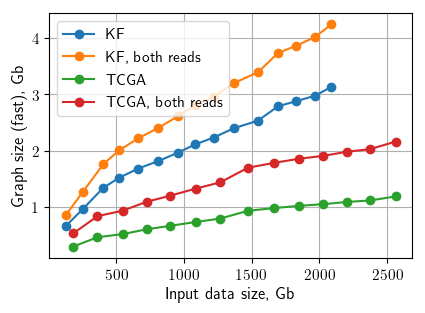

In [55]:
width = 3.487 * 1.5
height = width / 1.618

fig, ax = plt.subplots(1, 1, figsize=(width / 1.2, height))
#ax.set_title('RefSeq graph, with replaced \'N\'s')
#ax.set_title('RefSeq assembly graph')

ax.plot(np.array(input_kingsford) / 2**30,
        np.array(sizes_kingsford) / 2**30, marker='o', label='KF')
ax.plot(np.array(input_kingsford) / 2**30,
        np.array(sizes_kingsford_both) / 2**30, marker='o', label='KF, both reads')
#ax.plot(np.array(input_kingsford)[:len(sizes_king_anno)] / 2**30,
#        np.array(sizes_king_anno) / 2**30, marker='x', label='KF: annotation')
ax.plot(np.array(input_TCGA) / 2**30,
        np.array(sizes_TCGA) / 2**30, marker='o', label='TCGA')
ax.plot(np.array(input_TCGA[:len(sizes_TCGA_both)]) / 2**30,
        np.array(sizes_TCGA_both) / 2**30, marker='o', label='TCGA, both reads')
#ax.set_yscale('log')
ax.set_ylabel('Graph size (fast), Gb')
ax.set_xlabel('Input data size, Gb')
#ax.set_xticks(np.array(k_array))
ax.grid(True)
ax.legend(loc='best')

#plt.title('Aggressive filtering, 10+')
plt.tight_layout()
plt.savefig('graph_input_scalability.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Num of k-mers

### Full Kingsford

In [19]:
num_cols_kingsford = np.arange(175, 2600, 175)

In [20]:
files = pd.read_csv('~/projects2014-metagenome/scripts/kingsford/kingsford_filtered_list_shuffled.txt', header=None)[0].values

In [21]:
input_kingsford = [sum([os.path.getsize(x) for x in files[:x]]) for x in num_cols_kingsford]

In [22]:
!ls ~/big_graph/kingsford/partitions/graph_kingsford_k19_cols*

/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_k19_cols1050.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_k19_cols1225.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_k19_cols1400.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_k19_cols1575.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_k19_cols175.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_k19_cols1750.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_k19_cols1925.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_k19_cols2100.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_k19_cols2275.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_k19_cols2450.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_k19_cols2625.dbg
/cluster/home/mikhaika/big_graph/kingsford/p

In [31]:
import re

num_kmers = []
num_dummy_kmers = []

for x in num_cols_kingsford:
    with open('../big_graph/kingsford/partitions/log_assemble_kingsford_k19_cols{}.txt'.format(x), 'r') as f:
        text = f.readlines()
    dummy_kmers = []
    for line in text:
        line.strip()
        if re.match('.*Number of dummy k-mers with dummy prefix of length.*', line):
            dummy_kmers.append(int(line.split(' ')[-1]))
        if re.match('Graph chunk with .* k-mers was built in.*', line):
            num_kmers.append(int(line.split(' ')[3]))
    num_dummy_kmers.append(sum(dummy_kmers) + 1)
num_kmers, num_dummy_kmers

([1433363817,
  2603810427,
  3441110196,
  4161363078,
  4771501571,
  5407397310,
  5928391829,
  6373328114,
  6742490840,
  7274621208,
  7738324042,
  8103224880,
  8430427253,
  8901671629],
 [537814971,
  850358840,
  1135023786,
  1396633009,
  1587435253,
  1753576469,
  1876850409,
  2004625071,
  2131388305,
  2260006747,
  2392243543,
  2485831561,
  2594055167,
  2700906034])

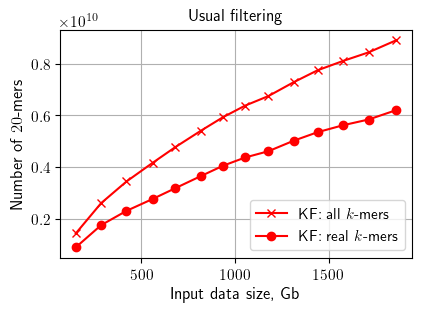

In [36]:
width = 3.487 * 1.5
height = width / 1.618

fig, ax = plt.subplots(1, 1, figsize=(width / 1.2, height))
#ax.set_title('RefSeq graph, with replaced \'N\'s')
#ax.set_title('RefSeq assembly graph')

#ax1_plot1 = ax.plot(np.array(k_array_refseq),
#                    np.array(sizes_refseq) / 2**20, marker='o', label='RS: size', c='b')
ax.plot(np.array(input_kingsford) / 2**30, num_kmers, marker='x', label='KF: all $k$-mers', c='r')
ax.plot(np.array(input_kingsford) / 2**30,
                 np.array(num_kmers) - np.array(num_dummy_kmers),
                 marker='o', label='KF: real $k$-mers', c='r')
#ax.set_yscale('log')
ax.set_ylabel('Number of $20$-mers')
ax.set_xlabel('Input data size, Gb')
#ax.set_xticks(np.array(k_array))
ax.grid(True)
ax.legend(loc='lower right')

plt.title('Usual filtering')
plt.tight_layout()
plt.savefig('graph_input_scalability.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Kingsford without small files, $\geq250$ Mb

In [37]:
files = pd.read_csv('~/projects2014-metagenome/scripts/kingsford/kingsford_filtered_list_shuffled_filtered.txt', header=None)[0].values

In [38]:
num_cols_kingsford = np.arange(115, 1800, 115)

In [39]:
input_kingsford = [sum([os.path.getsize(x) for x in files[:x]]) for x in num_cols_kingsford]

In [40]:
!ls ~/big_graph/kingsford/partitions/graph_kingsford_without_small_k19_cols*

/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_without_small_k19_cols1035.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_without_small_k19_cols115.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_without_small_k19_cols1150.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_without_small_k19_cols1265.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_without_small_k19_cols1380.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_without_small_k19_cols1495.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_without_small_k19_cols1610.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_without_small_k19_cols1725.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_without_small_k19_cols230.dbg
/cluster/home/mikhaika/big_graph/kingsford/partitions/graph_kingsford_without_small_k19_cols3

In [41]:
import re

num_kmers = []
num_dummy_kmers = []

for x in num_cols_kingsford:
    with open('../big_graph/kingsford/partitions/log_assemble_kingsford_without_small_k19_cols{}.txt'.format(x), 'r') as f:
        text = f.readlines()
    dummy_kmers = []
    for line in text:
        line.strip()
        if re.match('.*Number of dummy k-mers with dummy prefix of length.*', line):
            dummy_kmers.append(int(line.split(' ')[-1]))
        if re.match('Graph chunk with .* k-mers was built in.*', line):
            num_kmers.append(int(line.split(' ')[3]))
    num_dummy_kmers.append(sum(dummy_kmers) + 1)
num_kmers, num_dummy_kmers

([1065475424,
  1657454528,
  2262181969,
  2835966619,
  3227608504,
  3593070378,
  3884500806,
  4168056950,
  4452689438,
  4748917448,
  4975241768,
  5280522961,
  5514891191,
  5755253634,
  6059724057],
 [471727388,
  741686900,
  1005068033,
  1237434638,
  1404626091,
  1546681692,
  1664272952,
  1781597085,
  1904524783,
  2025489585,
  2117081904,
  2223821772,
  2325681739,
  2412431905,
  2546020726])

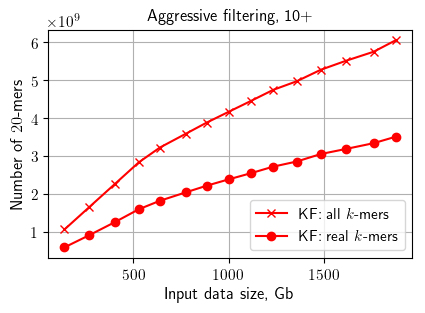

In [42]:
width = 3.487 * 1.5
height = width / 1.618

fig, ax = plt.subplots(1, 1, figsize=(width / 1.2, height))
#ax.set_title('RefSeq graph, with replaced \'N\'s')
#ax.set_title('RefSeq assembly graph')

#ax1_plot1 = ax.plot(np.array(k_array_refseq),
#                    np.array(sizes_refseq) / 2**20, marker='o', label='RS: size', c='b')
ax.plot(np.array(input_kingsford) / 2**30, num_kmers, marker='x', label='KF: all $k$-mers', c='r')
ax.plot(np.array(input_kingsford) / 2**30,
                 np.array(num_kmers) - np.array(num_dummy_kmers),
                 marker='o', label='KF: real $k$-mers', c='r')
#ax.set_yscale('log')
ax.set_ylabel('Number of $20$-mers')
ax.set_xlabel('Input data size, Gb')
#ax.set_xticks(np.array(k_array))
ax.grid(True)
ax.legend(loc='lower right')

plt.title('Aggressive filtering, 10+')
plt.tight_layout()
plt.savefig('graph_input_scalability.pdf', format='pdf', bbox_inches='tight')
plt.show()